# Creation and training of CS-NeuralFMUs
Tutorial by Johannes Stoljar, Tobias Thummerer

## License
Copyright (c) 2021 Tobias Thummerer, Lars Mikelsons, Johannes Stoljar

Licensed under the MIT license. See [LICENSE](https://github.com/thummeto/FMIFlux.jl/blob/main/LICENSE) file in the project root for details.

## Motivation
The Julia Package *FMIFlux.jl* is motivated by the application of hybrid modeling. This package enables the user to integrate his simulation model between neural networks (NeuralFMU). For this, the simulation model must be exported as FMU (functional mock-up unit), which corresponds to a widely used standard. The big advantage of hybrid modeling with artificial neural networks is, that effects that are difficult to model (because they might be unknown) can be easily learned by the neural networks. For this purpose, the NeuralFMU is trained with measurement data containing the unmodeled physical effect. The final product is a simulation model including the orignially unmodeled effects. Another big advantage of the NeuralFMU is that it works with little data, because the FMU already contains the characterisitic functionality of the simulation and only the missing effects are added.

NeuralFMUs need not to be as easy as in this example. Basically a NeuralFMU can combine different ANN topologies that manipulate any FMU-input (system state, system inputs, time) and any FMU-output (system state derivative, system outputs, other system variables). However, for this example a NeuralFMU topology as shown in the following picture is used.

![CS-NeuralFMU.svg](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/pics/CSNeuralFMU.svg?raw=true)

*NeuralFMU (CS) from* [[1]](#Source).

## Introduction to the example
In this example, the model of a one-dimensional spring pendulum (with an external acting force) is used to learn the initial states. For this purpose, on the one hand the initial position of the mass of the pendulum is shifted and on the other hand the default position of the mass from the model is used. The model with the shifted initial position serves as reference and is called *referenceFMU* in the following. The model with the default position is further referenced with *defaultFMU*. At the beginning, the actual state of both simulations is shown, whereby clear deviations can be seen in the graphs. Afterwards, the *defaultFMU* is integrated into a co-simulation NeuralFMU (CS-NeuralFMU) architecture. By training the NeuralFMU, an attempt is made to learn the initial displacement of the *referenceFMU*. It can be clearly seen that the NeuralFMU learns this shift well in just a few training steps. 


## Target group
The example is primarily intended for users who work in the field of first principle and/or hybrid modeling and are further interested in hybrid model building. The example wants to show how simple it is to combine FMUs with machine learning and to illustrate the advantages of this approach.


## Other formats
Besides this [Jupyter Notebook](https://github.com/thummeto/FMIFlux.jl/blob/main/example/simple_hybrid_CS.ipynb) there is also a [Julia file](https://github.com/thummeto/FMIFlux.jl/blob/main/example/simple_hybrid_CS.jl) with the same name, which contains only the code cells and for the documentation there is a [Markdown file](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/simple_hybrid_CS.md) corresponding to the notebook.  


## Getting started

### Installation prerequisites
|    | Description                       | Command     |  Alternative  |   
|:--- |:---                               |:---        |:---|
|1.  | Enter Package Manager via         |     ]       |     |
|2.  | Install FMI via                   |   add FMI   | add " https://github.com/ThummeTo/FMI.jl "   |
|3.  | Install FMIFlux via               | add FMIFlux | add " https://github.com/ThummeTo/FMIFlux.jl " |
|4.  | Install FMIZoo via                | add FMIZoo  | add " https://github.com/ThummeTo/FMIZoo.jl " |
|5.  | Install Flux via                  |  add Flux   |     |
|6.  | Install DifferentialEquations via | add DifferentialEquations |  |
|7.  | Install Plots via                 | add Plots   |     |
|8.  | Install Random via                | add Random  |     |

## Code section

To run the example, the previously installed packages must be included. 

In [1]:
# imports
using FMI
using FMIFlux
using FMIZoo
using Flux
using DifferentialEquations: Tsit5
import Plots

# set seed
import Random
Random.seed!(1234);

After importing the packages, the path to the *Functional Mock-up Units* (FMUs) is set. The FMU is a model exported meeting the *Functional Mock-up Interface* (FMI) Standard. The FMI is a free standard ([fmi-standard.org](http://fmi-standard.org/)) that defines a container and an interface to exchange dynamic models using a combination of XML files, binaries and C code zipped into a single file. 

The objec-orientated structure of the *SpringPendulumExtForce1D* can be seen in the following graphic. This model is a simple spring pendulum without friction, but with an external force. 

![svg](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/pics/SpringPendulumExtForce1D.svg?raw=true)

Next, the start time and end time of the simulation are set. Finally, a step size is specified to store the results of the simulation at these time steps.

In [2]:
tStart = 0.0
tStep = 0.01
tStop = 5.0
tSave = tStart:tStep:tStop

0.0:0.01:5.0

### ReferenceFMU

In the next lines of code the FMU of the *referenceFMU* model is loaded from *FMIZoo.jl* and instantiated.  

In [3]:
referenceFMU = fmiLoad("SpringPendulumExtForce1D", "Dymola", "2022x")
fmiInstantiate!(referenceFMU; loggingOn=false)
fmiInfo(referenceFMU)

┌ Info: fmi2Unzip(...): Successfully unzipped 153 files at `/tmp/fmijl_XJhn01/SpringPendulumExtForce1D`.
└ @ FMIImport /home/runner/.julia/packages/FMIImport/S8pFT/src/FMI2_ext.jl:75
┌ Info: fmi2Load(...): FMU resources location is `file:////tmp/fmijl_XJhn01/SpringPendulumExtForce1D/resources`
└ @ FMIImport /home/runner/.julia/packages/FMIImport/S8pFT/src/FMI2_ext.jl:190
┌ Info: fmi2Load(...): FMU supports both CS and ME, using CS as default if nothing specified.
└ @ FMIImport /home/runner/.julia/packages/FMIImport/S8pFT/src/FMI2_ext.jl:193


#################### Begin information for FMU ####################
	Model name:			SpringPendulumExtForce1D
	FMI-Version:			2.0
	GUID:				{7d007818-e354-47c7-9222-cdc1c9e53a24}
	Generation tool:		Dymola Version 2022x (64-bit), 2021-10-08
	Generation time:		2022-03-18T07:57:54Z
	Var. naming conv.:		structured
	Event indicators:		0
	Inputs:				1
		352321536 ["extForce"]
	Outputs:			2
		335544320 ["accSensor.v", "der(accSensor.flange.s)", "v", "der(speedSensor.flange.s)", "speedSensor.v"]
		335544321 ["der(accSensor.v)", "a", "accSensor.a"]
	States:				2
		33554432 ["mass.s"]
		33554433 ["mass.v"]
	Supports Co-Simulation:		true
		Model identifier:	SpringPendulumExtForce1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
		Var. com. steps:	true
		Input interpol.:	true
		Max order out. der.:	1
	Supports Model-Exchange:	true
		Model identifier:	SpringPendulumExtForce1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
##################### End inf

Both the start and end time are set via the *fmiSetupExperiment()* function. In addition, the initial position of the mass is set to a value of $1.3m$  The experiment is initialized to get the information of the continuous states. You can get all continuous states of a FMU by the function *fmiGetContinuousStates()* and this is also done for the *referenceFMU*. It has two states: The first state is the previously initialized position of the mass, the second state is the velocity, which is initialized with $0\frac{m}{s}$.   

In [4]:
fmiSetupExperiment(referenceFMU, tStart, tStop)
fmiSetReal(referenceFMU, "mass_s0", 1.3)   # increase amplitude, invert phase
fmiEnterInitializationMode(referenceFMU)
fmiExitInitializationMode(referenceFMU)

x₀ = fmiGetContinuousStates(referenceFMU)

2-element Vector{Float64}:
 1.3
 0.0

In the following code block the *referenceFMU* is simulated, still specifying which variables are included. After the simulation is finished the result of the *referenceFMU* can be plotted. This plot also serves as a reference for the later CS-NeuralFMU model.

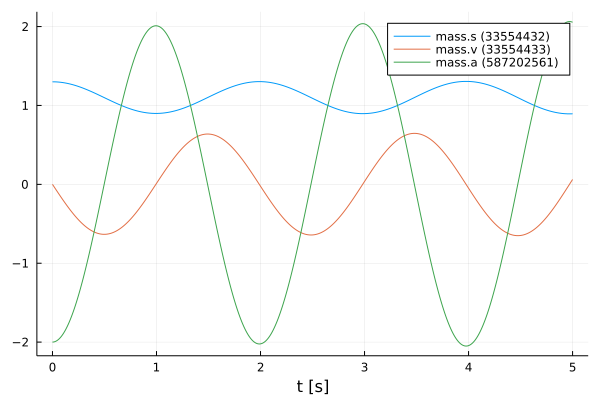

In [5]:
parameter = Dict("mass_s0" => 1.3)
vrs = ["mass.s", "mass.v", "mass.a"]
solution = fmiSimulate(referenceFMU, tStart, tStop; parameters=parameter, recordValues=vrs, saveat=tSave, reset=false)
fmiPlot(solution)

The data from the simualtion of the *referenceFMU*, are divided into position, velocity and acceleration data. The data for the acceleration will be needed later. 

In [6]:
referenceSimData = solution.values.saveval
posReference = collect(data[1] for data in referenceSimData)
velReference = collect(data[2] for data in referenceSimData)
accReference = collect(data[3] for data in referenceSimData)

501-element Vector{Float64}:
 -1.9999999999999996
 -1.9988827275812904
 -1.9958127258179004
 -1.9907908533763607
 -1.9837918439669844
 -1.9748258342855118
 -1.963890162864621
 -1.9510089134488018
 -1.9361810148909009
 -1.9194099484303728
 -1.9007374108186537
 -1.8801634598739092
 -1.8576990114645708
  ⋮
  1.9971927754348462
  2.0126501310664713
  2.026070116129912
  2.037424725618772
  2.0467236772128947
  2.0541004250985972
  2.0594240680173828
  2.062679095787284
  2.0638499982263325
  2.0629212651525553
  2.059877386383986
  2.0548550901379925

### DefaultFMU

The following is a reset for the *referenceFMU* and a renaming to *defaultFMU*. After the reset, the previous initial position of the mass is not set, so the default position of the *defaultFMU* is used. The first state indicates the position of the mass, which is initilized with $0.5𝑚$.

In [7]:
fmiTerminate(referenceFMU)
fmiReset(referenceFMU)
defaultFMU = referenceFMU

fmiSetupExperiment(defaultFMU, tStart, tStop)
fmiEnterInitializationMode(defaultFMU)
fmiExitInitializationMode(defaultFMU)

x₀ = fmiGetContinuousStates(defaultFMU)

2-element Vector{Float64}:
 0.5
 0.0

The following simulate and plot the *defaultFMU* just like the *referenceFMU*. The differences between both systems can be clearly seen from the plots. In the plots for the *defaultFMU* you can see that other oscillations occur due to the different starting positions. On the one hand the oscillation of the *defaultFMU* starts in the opposite direction of the *referenceFMU* and on the other hand the graphs for the velocity and acceleration differ clearly in the amplitude. In the following we try to learn the initial shift of the position so that the graphs for the acceleration of both graphs match.

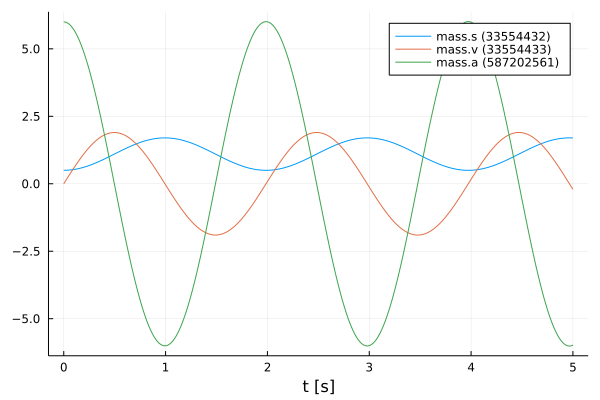

In [8]:
solution = fmiSimulate(defaultFMU, tStart, tStop; recordValues=vrs, saveat=tSave, reset=false)
fmiPlot(solution)

The data from the simualtion of the *defaultFMU*, are divided into position, velocity and acceleration data. The data for the acceleration will be needed later.

In [9]:
defaultSimData = solution.values.saveval
posDefault = collect(data[1] for data in defaultSimData)
velDefault = collect(data[2] for data in defaultSimData)
accDefault = collect(data[3] for data in defaultSimData)

501-element Vector{Float64}:
  6.0
  5.996872980925033
  5.987824566254761
  5.9728274953129645
  5.95187583433241
  5.9249872805026715
  5.892169834645022
  5.853465119227542
  5.808892969264781
  5.75851573503067
  5.702370188387734
  5.640527685538739
  5.573049035471661
  ⋮
 -5.842615646003006
 -5.884869953422783
 -5.921224800662572
 -5.9516502108284985
 -5.976144547672481
 -5.994659284032171
 -6.007174453690571
 -6.013675684067705
 -6.014154196220591
 -6.008606804843264
 -5.997055285530499
 -5.979508813705998

## CS-NeuralFMU

In this section, the *defaultFMU* is inserted into a CS-NeuralFMU architecture. It has the goal to learn the initial state of the *referenceFMU*.


For the external force, a simple function is implemented that always returns a force of $0N$ at each time point. Also, all other functions and implementations would be possible here. Only for simplification reasons the function was chosen so simply.

In [10]:
function extForce(t)
    return [0.0]
end 

extForce (generic function with 1 method)

#### Loss function

In order to train our model, a loss function must be implemented. The solver of the NeuralFMU can calculate the gradient of the loss function. The gradient descent is needed to adjust the weights in the neural network so that the sum of the error is reduced and the model becomes more accurate.

The loss function in this implmentation consists of the mean squared error (mse) from the acceleration data of the *referenceFMU* simulation (`accReference`) and the acceleration data of the network (`accNet`).
$$ mse = \frac{1}{n} \sum\limits_{i=0}^n (accReference[i] - accNet[i])^2 $$

In [11]:
# loss function for training
function lossSum()
    solution = csNeuralFMU(extForce, tStep)

    accNet = collect(data[1] for data in solution.values.saveval)
    
    Flux.Losses.mse(accReference, accNet)
end

lossSum (generic function with 1 method)

#### Callback

To output the loss in certain time intervals, a callback is implemented as a function in the following. Here a counter is incremented, every twentieth pass the loss function is called and the average error is printed out.

In [12]:
# callback function for training
global counter = 0
function callb()
    global counter += 1

    if counter % 20 == 1
        avgLoss = lossSum()
        @info "Loss [$counter]: $(round(avgLoss, digits=5))"
    end
end

callb (generic function with 1 method)

#### Structure of the CS-NeuralFMU

In the following, the topology of the CS-NeuralFMU is constructed. It consists of an input layer, which then leads into the *defaultFMU* model. The CS-FMU computes the outputs for the given system state and time step. After the *defaultFMU* follows a dense layer, which has exactly as many inputs as the model has outputs. The output of this layer consists of 16 output nodes and a *tanh* activation function. The next layer has 16 input and output nodes with the same activation function. The last layer is again a dense layer with 16 input nodes and the number of model outputs as output nodes. Here, it is important that no *tanh*-activation function follows, because otherwise the pendulums state values would be limited to the interval $[-1;1]$.

In [13]:
# NeuralFMU setup
numInputs = length(defaultFMU.modelDescription.inputValueReferences)
numOutputs = length(defaultFMU.modelDescription.outputValueReferences)

net = Chain(inputs -> fmiInputDoStepCSOutput(defaultFMU, tStep, inputs),
            Dense(numOutputs, 16, tanh),
            Dense(16, 16, tanh),
            Dense(16, numOutputs))

Chain(
  var"#15#16"(),
  Dense(2, 16, tanh),                   # 48 parameters
  Dense(16, 16, tanh),                  # 272 parameters
  Dense(16, 2),                         # 34 parameters
)                   # Total: 6 arrays, 354 parameters, 1.758 KiB.

#### Definition of the CS-NeuralFMU

The instantiation of the CS-NeuralFMU is done as a one-liner. The FMU `defaultFMU`, the structure of the network `net`, start `tStart` and end time `tStop`, and the time steps `tSave` for saving are specified.

In [14]:
csNeuralFMU = CS_NeuralFMU(defaultFMU, net, (tStart, tStop); saveat=tSave);

#### Plot before training

Here the state trajactory of the *extForceFMU* is recorded. Doesn't really look like a pendulum yet, but the system is random initialized by default. In the later plots, the effect of learning can be seen.

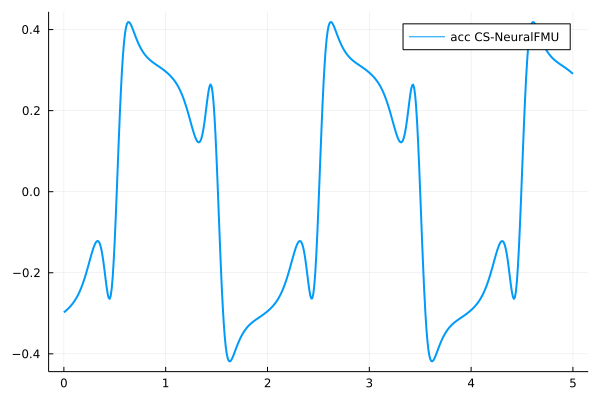

In [15]:
solutionBefore = csNeuralFMU(extForce, tStep)
Plots.plot(tSave, collect(data[1] for data in solutionBefore.values.saveval), label="acc CS-NeuralFMU", linewidth=2)

#### Training of the CS-NeuralFMU

For the training of the CS-NeuralFMU the parameters are extracted. The known ADAM optimizer for minimizing the gradient descent is used as further passing parameters. In addition, the previously defined loss and callback function, as well as the number of epochs are passed.

In [16]:
# train
paramsNet = Flux.params(csNeuralFMU)

optim = ADAM()
Flux.train!(lossSum, paramsNet, Iterators.repeated((), 300), optim; cb=callb)

┌ Info: Loss [1]: 1.31473
└ @ Main In[12]:8
┌ Info: Loss [21]: 0.13349
└ @ Main In[12]:8
┌ Info: Loss [41]: 0.07489
└ @ Main In[12]:8
┌ Info: Loss [61]: 0.04067
└ @ Main In[12]:8
┌ Info: Loss [81]: 0.02535
└ @ Main In[12]:8
┌ Info: Loss [101]: 0.01475
└ @ Main In[12]:8
┌ Info: Loss [121]: 0.00847
└ @ Main In[12]:8
┌ Info: Loss [141]: 0.00507
└ @ Main In[12]:8
┌ Info: Loss [161]: 0.00335
└ @ Main In[12]:8
┌ Info: Loss [181]: 0.00249
└ @ Main In[12]:8
┌ Info: Loss [201]: 0.002
└ @ Main In[12]:8
┌ Info: Loss [221]: 0.00168
└ @ Main In[12]:8
┌ Info: Loss [241]: 0.00144
└ @ Main In[12]:8
┌ Info: Loss [261]: 0.00124
└ @ Main In[12]:8
┌ Info: Loss [281]: 0.00108
└ @ Main In[12]:8


#### Comparison of the plots

Here three plots are compared with each other and only the acceleration of the mass is considered. The first plot represents the *defaultFMU*, the second represents the *referenceFMU* and the third plot represents the result after training the CS-NeuralFMU. 

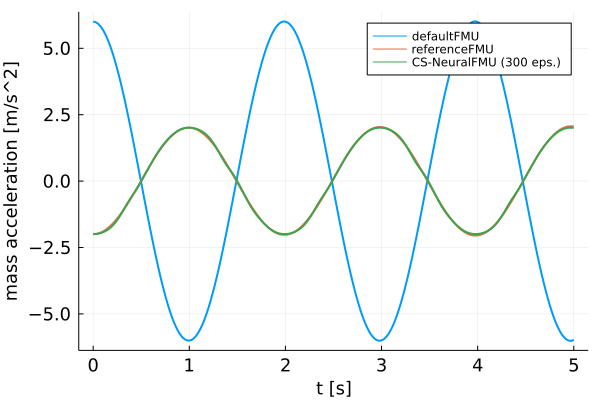

In [17]:
# plot results mass.a
solutionAfter = csNeuralFMU(extForce, tStep)

fig = Plots.plot(xlabel="t [s]", ylabel="mass acceleration [m/s^2]", linewidth=2,
                 xtickfontsize=12, ytickfontsize=12,
                 xguidefontsize=12, yguidefontsize=12,
                 legendfontsize=8, legend=:topright)

accNeuralFMU = collect(data[1] for data in solutionAfter.values.saveval)

Plots.plot!(fig, tSave, accDefault, label="defaultFMU", linewidth=2)
Plots.plot!(fig, tSave, accReference, label="referenceFMU", linewidth=2)
Plots.plot!(fig, tSave, accNeuralFMU, label="CS-NeuralFMU (300 eps.)", linewidth=2)
fig 

Finally, the FMU is cleaned-up.

In [18]:
fmiUnload(defaultFMU)

### Summary

Based on the plots, it can be clearly seen that the CS-NeuralFMU model is able to learn the shift of the initial position. Even after only 300 runs, the curves overlap very much, so no further training with more runs is needed.

### Source

[1] Tobias Thummerer, Lars Mikelsons and Josef Kircher. 2021. **NeuralFMU: towards structural integration of FMUs into neural networks.** Martin Sjölund, Lena Buffoni, Adrian Pop and Lennart Ochel (Ed.). Proceedings of 14th Modelica Conference 2021, Linköping, Sweden, September 20-24, 2021. Linköping University Electronic Press, Linköping (Linköping Electronic Conference Proceedings ; 181), 297-306. [DOI: 10.3384/ecp21181297](https://doi.org/10.3384/ecp21181297)
